[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/tutorials/zh_cn/beginner/mindspore_dataset.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/tutorials/zh_cn/beginner/mindspore_dataset.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/tutorials/source_zh_cn/beginner/dataset.ipynb)

[基本介绍](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/introduction.html) || [快速入门](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/quick_start.html) || [张量 Tensor](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/tensor.html) || **数据集 Dataset** || [数据变换 Transforms](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/transforms.html) || [网络构建](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/model.html) || [函数式自动微分](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/autograd.html) || [模型训练](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/train.html) || [保存与加载](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/save_load.html) || [推理与部署](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/infer.html)

# 数据集 Dataset

数据是深度学习的基础，高质量的数据输入将在整个深度神经网络中起到积极作用。MindSpore提供基于Pipeline的[数据引擎](https://www.mindspore.cn/docs/zh-CN/master/design/data_engine.html)，通过[数据集（Dataset）](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/dataset.html)和[数据变换（Transforms）](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/transforms.html)实现高效的数据预处理。其中Dataset是Pipeline的起始，用于加载原始数据。`mindspore.dataset`提供了内置的文本、图像、音频等数据集加载接口，并提供了自定义数据集加载接口。

此外MindSpore的领域开发库也提供了大量的预加载数据集，可以使用API一键下载使用。本教程将分别对不同的数据集加载方式、数据集常见操作和自定义数据集方法进行详细阐述。

In [1]:
import numpy as np
from mindspore.dataset import vision
from mindspore.dataset import MnistDataset, GeneratorDataset
import matplotlib.pyplot as plt

## 数据集加载

我们使用**Mnist**数据集作为样例，介绍使用`mindspore.dataset`进行加载的方法。

`mindspore.dataset`提供了大量的数据集加载接口，这里我们仍以Mnist为例，直接利用已下载好的数据集文件进行加载。`mindspore.dataset`提供的接口**仅支持解压后的数据文件**，因此我们先删除压缩文件。

In [2]:
# Download data from open datasets
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/" \
      "notebook/datasets/MNIST_Data.zip"
path = download(url, "./", kind="zip", replace=True)


file_sizes: 100%|██████████████████████████| 10.8M/10.8M [00:02<00:00, 3.96MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


压缩文件删除后，直接加载，可以看到其数据类型为MnistDataset。

In [3]:
train_dataset = MnistDataset("MNIST_Data/train", shuffle=False)
print(type(train_dataset))

<class 'mindspore.dataset.engine.datasets_vision.MnistDataset'>


## 数据集迭代

数据集加载后，一般以迭代方式获取数据，然后送入神经网络中进行训练。我们可以用`create_tuple_iterator`或`create_dict_iterator`接口创建数据迭代器，迭代访问数据。

访问的数据类型默认为`Tensor`；若设置`output_numpy=True`，访问的数据类型为`Numpy`。

下面定义一个可视化函数，迭代9张图片进行展示。

In [4]:
def visualize(dataset):
    figure = plt.figure(figsize=(4, 4))
    cols, rows = 3, 3

    for idx, (image, label) in enumerate(dataset.create_tuple_iterator()):
        figure.add_subplot(rows, cols, idx + 1)
        plt.title(int(label))
        plt.axis("off")
        plt.imshow(image.asnumpy().squeeze(), cmap="gray")
        if idx == cols * rows - 1:
            break
    plt.show()

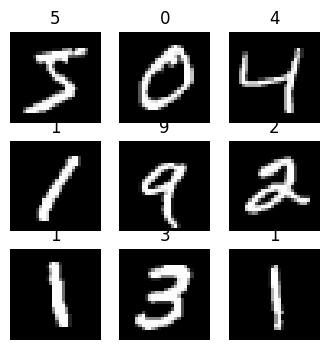

In [5]:
visualize(train_dataset)

## 数据集常用操作

Pipeline的设计理念使得数据集的常用操作采用`dataset = dataset.operation()`的异步执行方式，执行操作返回新的Dataset，此时不执行具体操作，而是在Pipeline中加入节点，最终进行迭代时，并行执行整个Pipeline。

下面分别介绍几种常见的数据集操作。

### shuffle

数据集随机`shuffle`可以消除数据排列造成的分布不均问题。

![op-shuffle](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/source_zh_cn/advanced/dataset/images/op_shuffle.png)

`mindspore.dataset`提供的数据集在加载时可配置`shuffle=True`，或使用如下操作：

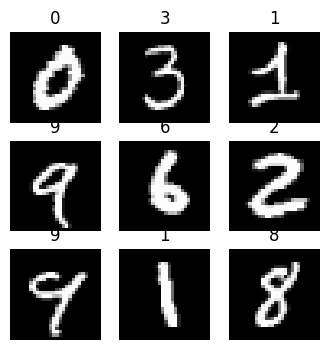

In [6]:
train_dataset = train_dataset.shuffle(buffer_size=64)

visualize(train_dataset)

### map

`map`操作是数据预处理的关键操作，可以针对数据集指定列（column）添加数据变换（Transforms），将数据变换应用于该列数据的每个元素，并返回包含变换后元素的新数据集。这里我们对Mnist数据集做数据缩放处理，将图像统一除255，数据类型由uint8转为float32。

> Dataset支持的不同变换类型详见[数据变换Transforms](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/transforms.html)。

In [7]:
image, label = next(train_dataset.create_tuple_iterator())
print(image.shape, image.dtype)

(28, 28, 1) UInt8


In [8]:
train_dataset = train_dataset.map(vision.Rescale(1.0 / 255.0, 0), input_columns='image')

对比map前后的数据，可以看到数据类型变化。

In [9]:
image, label = next(train_dataset.create_tuple_iterator())
print(image.shape, image.dtype)

(28, 28, 1) Float32


### batch

将数据集打包为固定大小的`batch`是在有限硬件资源下使用梯度下降进行模型优化的折中方法，可以保证梯度下降的随机性和优化计算量。

![op-batch](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/source_zh_cn/advanced/dataset/images/op_batch.png)

一般我们会设置一个固定的batch size，将连续的数据分为若干批（batch）。

In [10]:
train_dataset = train_dataset.batch(batch_size=32)

batch后的数据增加一维，大小为`batch_size`。

In [11]:
image, label = next(train_dataset.create_tuple_iterator())
print(image.shape, image.dtype)

(32, 28, 28, 1) Float32


## 自定义数据集

`mindspore.dataset`提供了部分常用数据集和标准格式数据集的加载接口。对于MindSpore暂不支持直接加载的数据集，可以通过构造自定义数据集类或自定义数据集生成函数的方式来生成数据集，然后通过`GeneratorDataset`接口实现自定义方式的数据集加载。

`GeneratorDataset`支持通过可迭代对象、迭代器和生成函数构造自定义数据集，下面分别对其进行详解。

### 可迭代对象

Python中可以使用for循环遍历出所有元素的，都可以称为可迭代对象(Iterable)，我们可以通过实现`__getitem__`方法来构造可迭代对象，并将其加载至`GeneratorDataset`。

In [12]:
# Iterable object as input source
class Iterable:
    def __init__(self):
        self._data = np.random.sample((5, 2))
        self._label = np.random.sample((5, 1))

    def __getitem__(self, index):
        return self._data[index], self._label[index]

    def __len__(self):
        return len(self._data)

In [13]:
data = Iterable()
dataset = GeneratorDataset(source=data, column_names=["data", "label"])

In [14]:
# list, dict, tuple are also iterable object.
dataset = GeneratorDataset(source=[(np.array(0),), (np.array(1),), (np.array(2),)], column_names=["col"])

### 迭代器

Python中内置有`__iter__`和`__next__`方法的对象，称为迭代器（Iterator）。下面构造一个简单迭代器，并将其加载至`GeneratorDataset`。

In [15]:
# Iterator as input source
class Iterator:
    def __init__(self):
        self._index = 0
        self._data = np.random.sample((5, 2))
        self._label = np.random.sample((5, 1))

    def __next__(self):
        if self._index >= len(self._data):
            raise StopIteration
        else:
            item = (self._data[self._index], self._label[self._index])
            self._index += 1
            return item

    def __iter__(self):
        self._index = 0
        return self

    def __len__(self):
        return len(self._data)

In [16]:
data = Iterator()
dataset = GeneratorDataset(source=data, column_names=["data", "label"])